<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>


# Introduction

The aim of this workbook is to use unsupervised learning to draw insights from a dataset.

## Lib Imports

In [25]:
import torch
from torch import nn
from tqdm.auto import tqdm
from dataclasses import dataclass
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [26]:
torch.manual_seed(0)

In [27]:
torch.cuda.is_available()

True

### Helper Methods


In [28]:
class Generator(nn.Module):
    def __init__(self,
                 input_dim=10,
                 input_channel=1,
                 hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.generator = nn.Sequential(
            self._make_gen_block(input_dim, hidden_dim * 4),
            self._make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self._make_gen_block(hidden_dim * 2, hidden_dim),
            self._make_gen_block(hidden_dim, input_channel, kernel_size=4, final_layer=True)
        )

    def _make_gen_block(self,
                        input_channels: int,
                        output_channels: int,
                        kernel_size=3,
                        stride=2,
                        final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [29]:
def get_noise(n_samples, input_dim, device="cpu"):
    return torch.randn(n_samples, input_dim, device=device)

In [30]:
class Discriminator(nn.Module):
    def __init__(self, image_channel=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._make_disc_block(image_channel, hidden_dim),
            self._make_disc_block(hidden_dim, hidden_dim * 2),
            self._make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )

    def _make_disc_block(self,
                         input_channels: int,
                         output_channels: int,
                         kernel_size=4,
                         stride=2,
                         final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, input):
        disc_pred = self.disc(input)
        return disc_pred.view(len(disc_pred), -1)

### Combined Vectors method

In [31]:
def combine_vectors(x, y):
    return torch.cat([x.float(), y.float()], axis=1)

In [32]:
if torch.cuda.is_available():
    cuda_check = combine_vectors(
        torch.tensor([[1, 2], [3, 4]]).cuda(),
        torch.tensor([[5, 6], [7, 8]]).cuda()
    )
    assert(str(cuda_check.device)).startswith("cuda")

combined = combine_vectors(
    torch.tensor([[1, 2], [3, 4]]).cuda(),
    torch.tensor([[5, 6], [7, 8]]).cuda()
)
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]], device="cuda", dtype=float))
assert (type(combined[0][0].item()) == float)

combined2 = combine_vectors(
    torch.randn(1, 4, 5),
    torch.randn(1, 8, 5)
)
assert tuple(combined2.shape) == (1, 12, 5)

### Get One Hot Labels Method

In [33]:
def get_one_hot_labels(labels, n_classes):
    return nn.functional.one_hot(labels, n_classes)

In [34]:
one_hot_labels = get_one_hot_labels(
    labels=torch.Tensor([[0, 2, 1]]).long(),
    n_classes=3
)
assert one_hot_labels.tolist() == [[
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
]]

if torch.cuda.is_available():
    cuda_one_hot_labels = get_one_hot_labels(
        torch.Tensor([[0]]).long().cuda(),
        1
    )
    assert str(cuda_one_hot_labels.device).startswith("cuda")

### Get Input Dimension Custom Method

In [35]:
@dataclass
class InputDimensions:
    generator_input_dim: int
    discriminator_image_channels: int


def get_input_dimensions(z_dim: int, mnist_shape: tuple[int], n_classes: int) -> InputDimensions:
    generator_input_dim = z_dim + n_classes
    discriminator_image_channels = mnist_shape[0] + n_classes

    return InputDimensions(
        generator_input_dim=generator_input_dim,
        discriminator_image_channels=discriminator_image_channels
    )

In [38]:
input_dimensions = get_input_dimensions(
    z_dim=23,
    mnist_shape=(12, 23, 52),
    n_classes=9
    )

assert input_dimensions.generator_input_dim == 32
assert input_dimensions.discriminator_image_channels == 21

### Hyperparameters

In [26]:
BATCH_SIZE = 128
Z_DIM = 64
IMAGE_SIZE = 28 * 28
NOISE_DIM = 100
NUM_CLASSES = 10
MNIST_SHAPE = (1, 28, 28)
NUM_EPOCHS = 20
LEARNING_RATE = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Data Loading and EDA

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [28]:
mnist = datasets.MNIST(
    root="./gan_data",
    train=True,
    transform=transform,
    download=True
)

In [29]:
data_loader = DataLoader(
    mnist,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [30]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

In [36]:
images.shape

torch.Size([64, 1, 28, 28])

In [35]:
labels

tensor([6, 8, 8, 7, 8, 0, 0, 5, 6, 0, 0, 3, 5, 8, 1, 6, 2, 4, 1, 4, 9, 4, 3, 4,
        1, 4, 8, 7, 6, 3, 1, 8, 4, 4, 6, 2, 4, 2, 9, 5, 7, 8, 0, 7, 5, 5, 9, 3,
        6, 6, 4, 6, 7, 8, 3, 6, 2, 2, 7, 7, 2, 4, 4, 9])

In [31]:
first_image = images[0].squeeze().numpy()
first_label = labels[0].item()

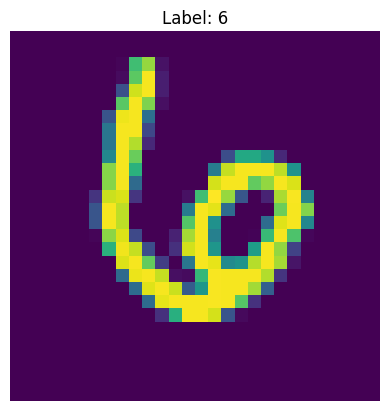

In [32]:
plt.imshow(first_image)
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

### 2. Model Training

### Loss Initialization

In [ ]:
input_dimensions = get_input_dimensions(
    z_dim=Z
)
generator = Generator(
    input_dim=
)

generator = Gene

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(NUM_EPOCHS):
    for real_images, labels in tqdm(data_loader):
        cur_batch_size = len(real_images)
        flattened_real_images = real_images.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), NUM_CLASSES)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, MNIST_SHAPE[1], MNIST_SHAPE[2])